In [1]:
import sys
sys.path.append("..")

import csaf
import csaf.utils as csafutils

from f16lib.acas import AcasScenario, AcasShieldScenario, AcasScenarioViewer
from f16lib.systems import F16AcasShieldIntruderBalloon

from IPython.display import HTML

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

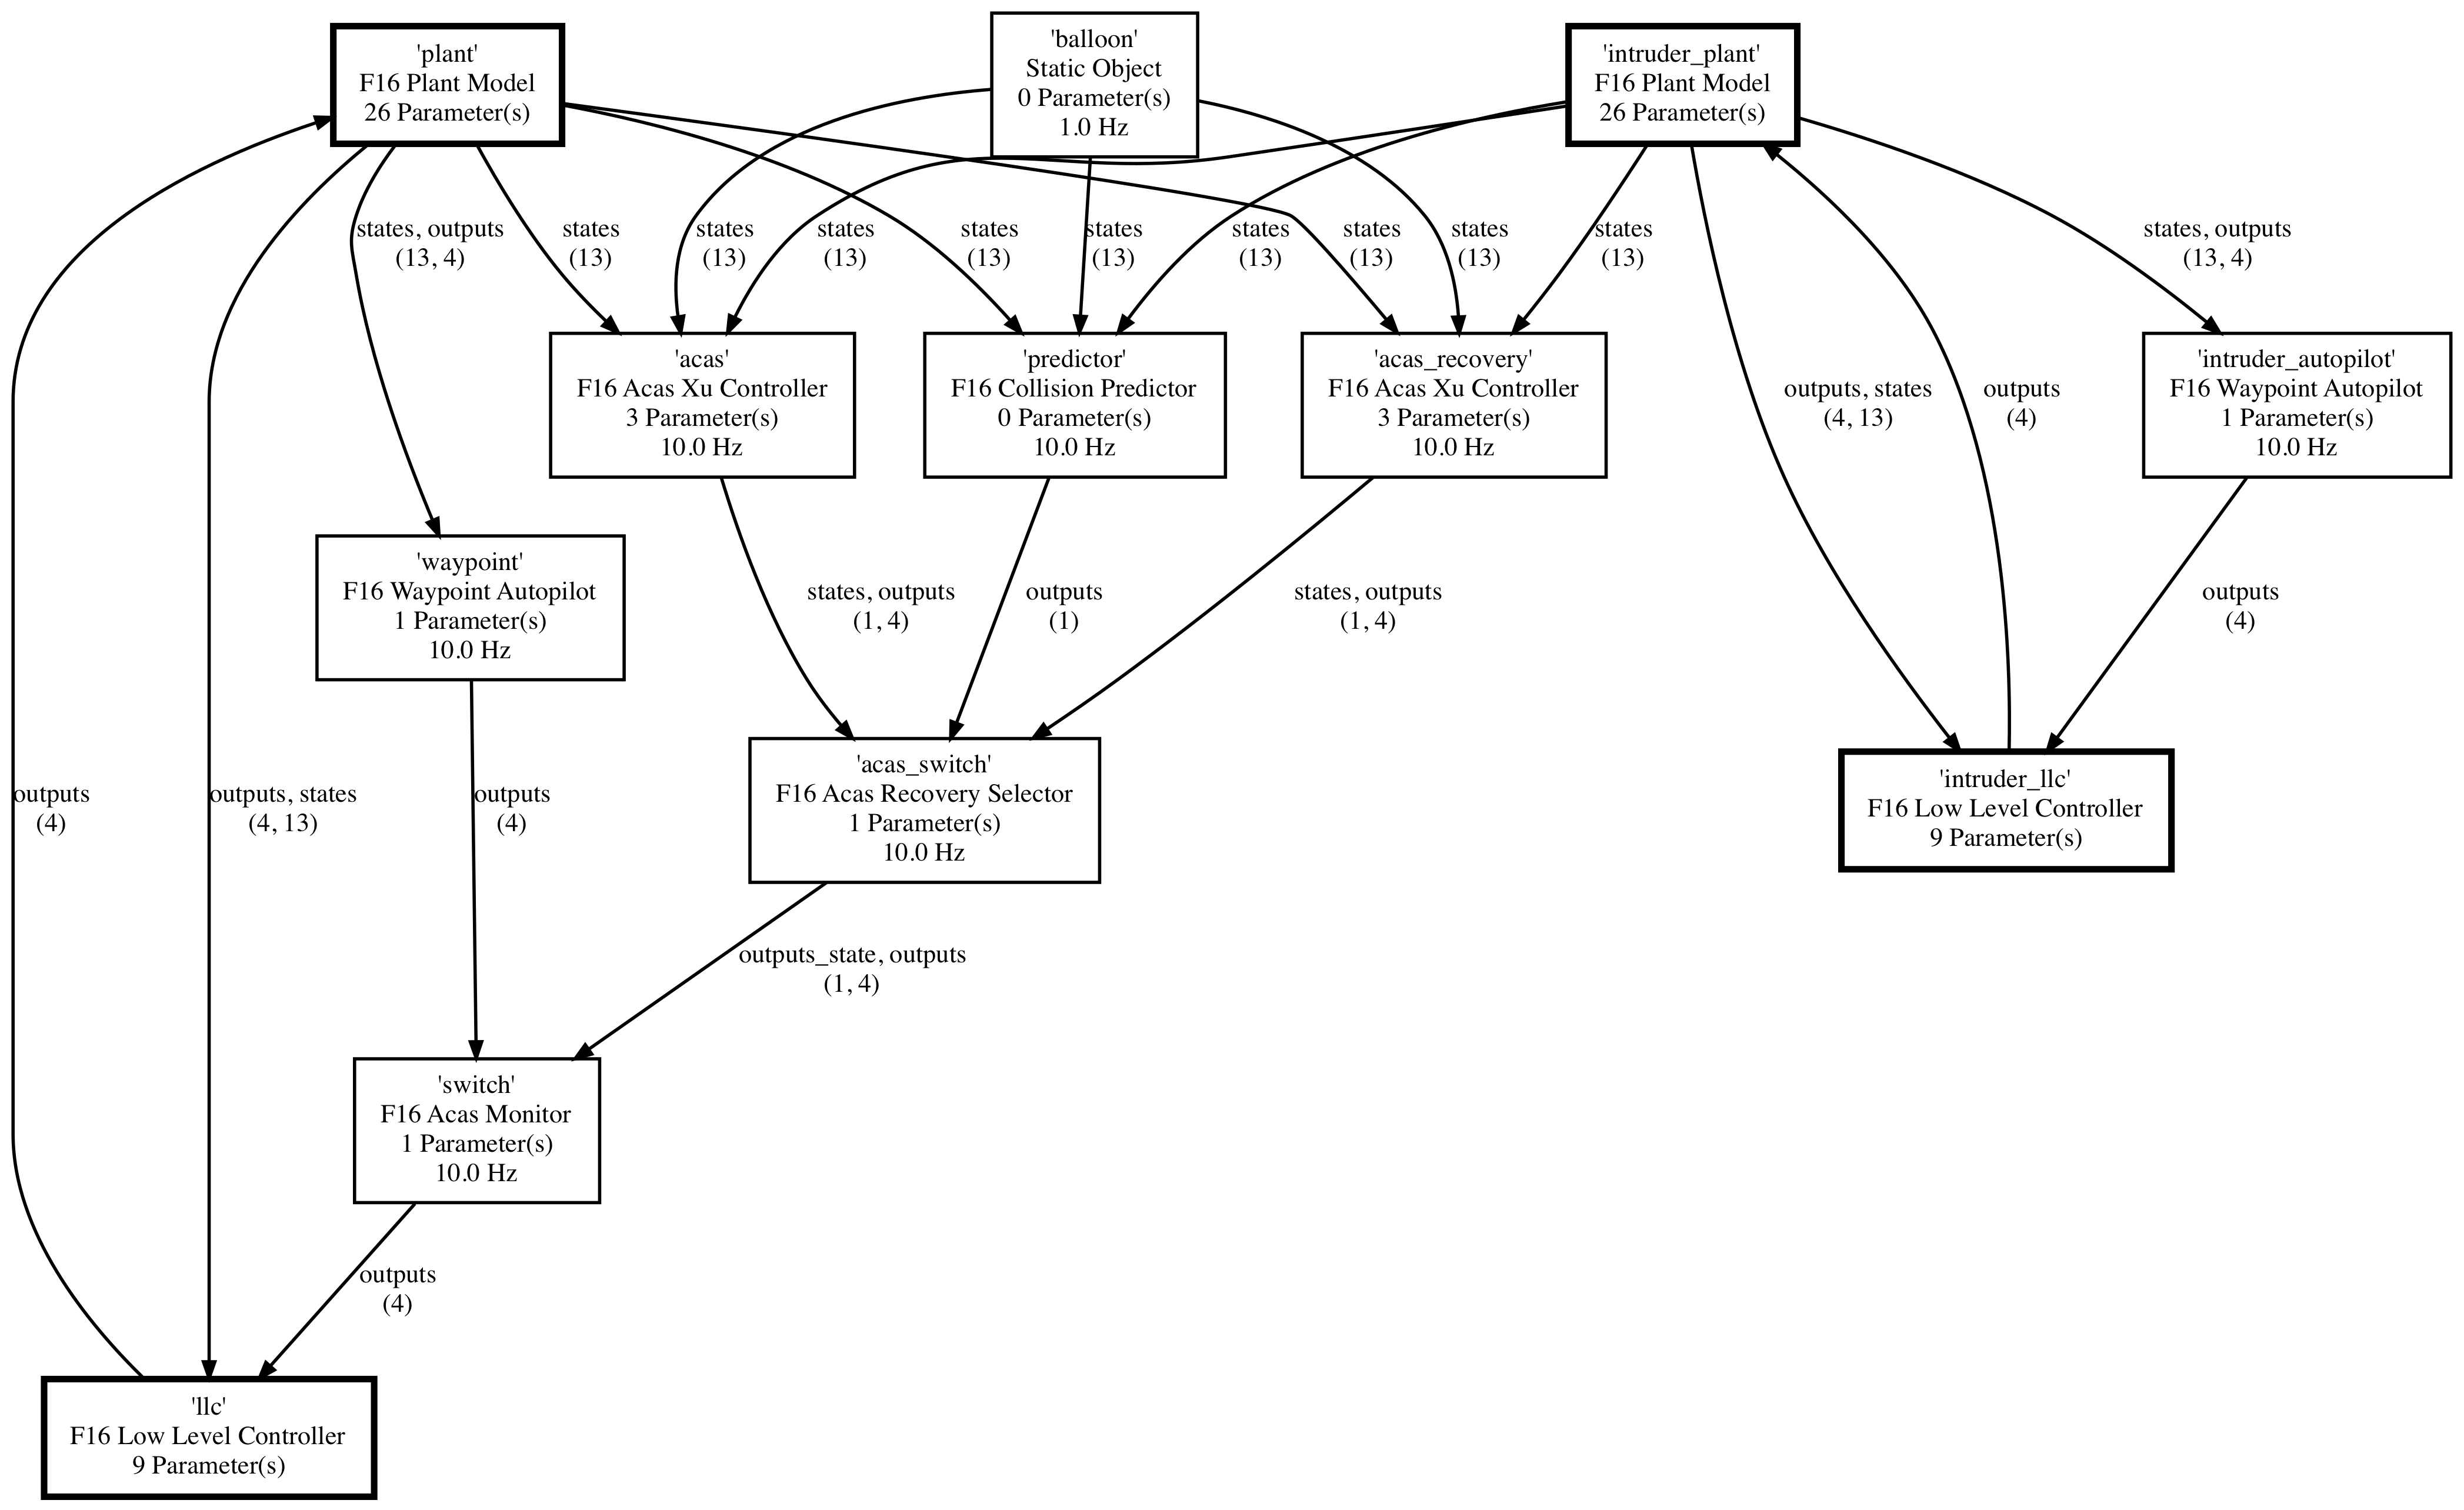

In [2]:
# check the system
AcasShieldScenario.system_type().check()

# view the system
csafutils.view_block_diagram(AcasShieldScenario.system_type, ipython_notebook=True)

In [3]:
YOFF = 1700
int_way = (-7000, 0.0+YOFF, 1000.0)

# construct a scenario
scen = AcasShieldScenario(
    [-2000.0, 5000+YOFF], # balloon position
    500.0, # ownship airspeed
    ((0.0, 15000.0+YOFF, 1000.0),(0.0, 20000.0+YOFF, 1000.0)), #((0.0, 20000, 1000.0), (5000.0, 30000, 1000.0), (10000, 20000, 1000.0)), # own waypoints
    (int_way,)
    #((-0.0, 4000.0, 1000.0),(-4000.0, 2500.0, 1000.0), (-8000, 4000, 1000.0)) # intruder waypoints
)

In [4]:
def air_collision_condition(ctraces):
        """ground collision premature termination condition
        """
        # get the aircraft states
        sa, sb, sc = ctraces['plant']['states'], ctraces['intruder_plant']['states'], ctraces['balloon']['states']
        if sa and sb and sc:
            # look at distance between last state
            dab =  (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sb[-1][9:11]))) 
            dac = (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sc[-1][9:11]))) 
            return dab < 500.0 or dac < 500.0

In [5]:
m = (8000+YOFF - int_way[1]) / (6000 - int_way[0])
theta = np.arctan2((6000 - int_way[0]), (8000+YOFF - int_way[1]))
#print(np.rad2deg(theta-3*np.pi/4))
x = 9000

sys = scen.create_system([x, (x-int_way[0])*m+int_way[1], # relative position
                          (theta+np.pi), # relative heading
                          -200.0]) # relative airspeed
sys.check()

True

In [6]:
trajs = sys.simulate_tspan((0.0, 60.0), show_status=True, terminating_conditions_all=air_collision_condition)

 26%|█████████▍                          | 3017/11464 [00:01<00:05, 1603.14it/s]


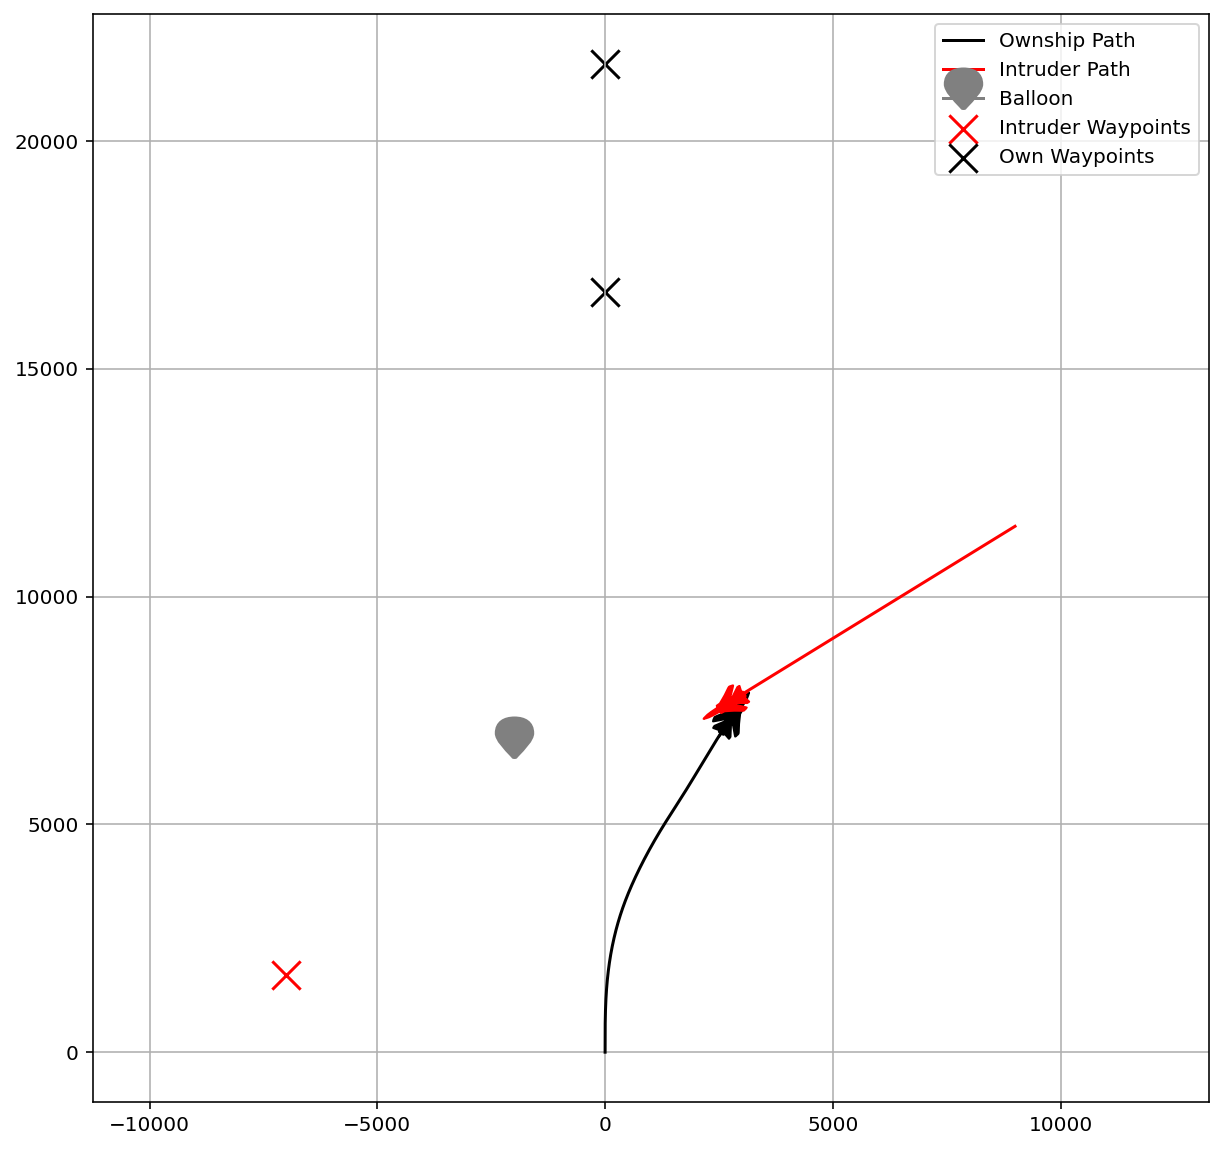

<Figure size 720x720 with 0 Axes>

In [7]:
viewer = AcasScenarioViewer(trajs, scen)
fig, ax = viewer.summary_plot()
plt.show()

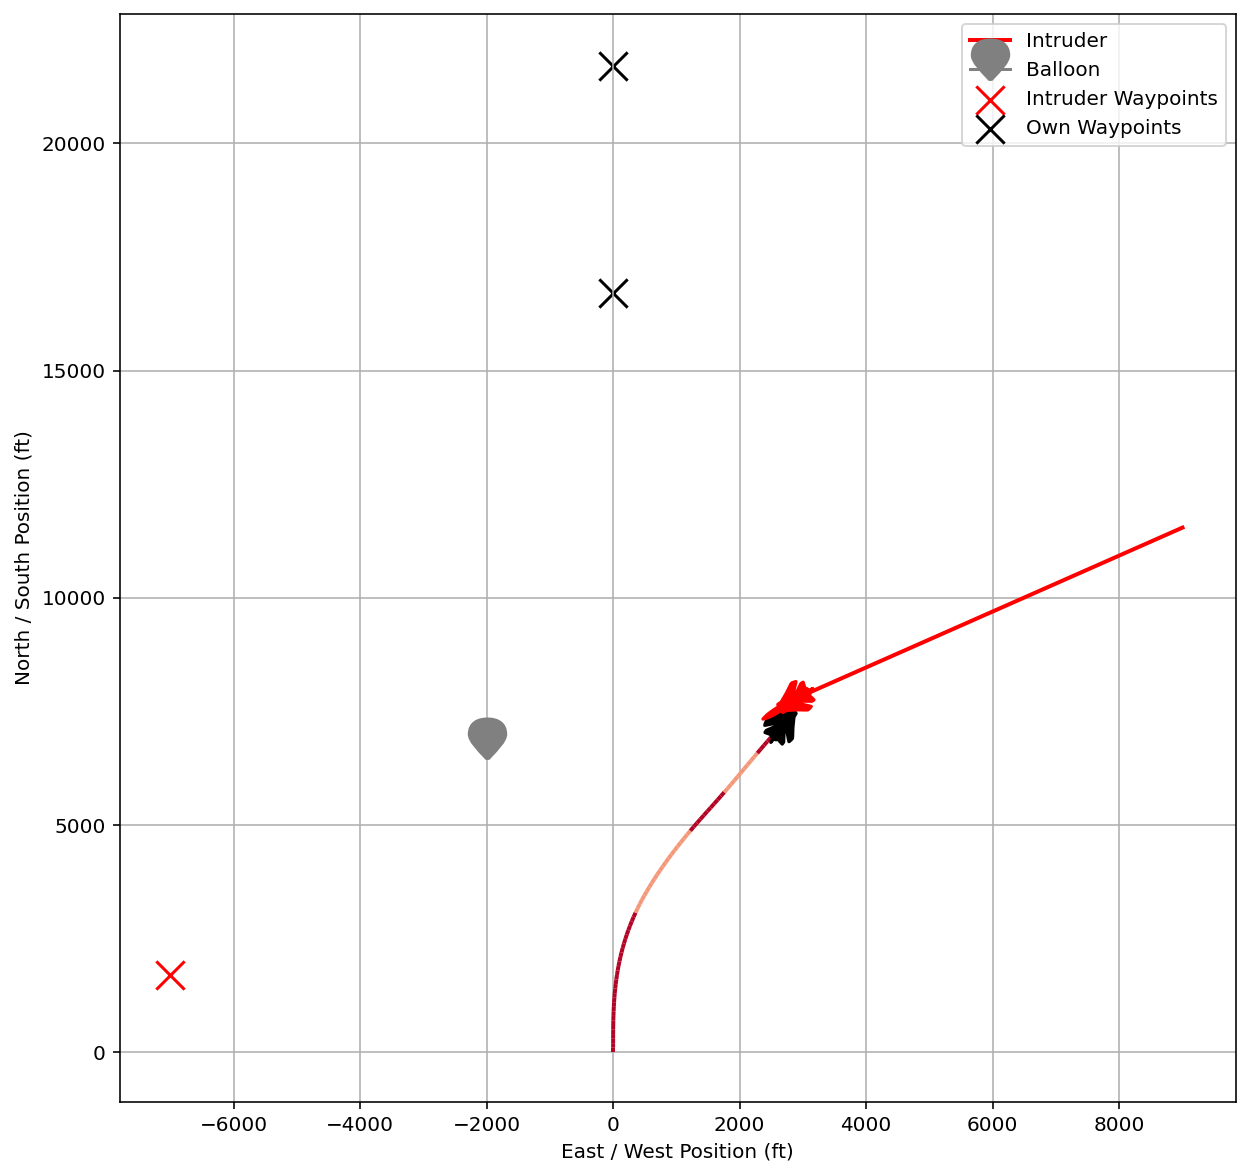

In [8]:
anim = viewer.summary_video()
HTML(anim.to_jshtml())

In [9]:
def task():
    c = np.random.random(4)
    c[0] *= 20000
    c[0] -= 10000
    c[1] *= 20000
    c[1] -= 10000
    c[2] *= np.pi * 2
    c[2] -= np.pi
    c[3] *= 0
    c[3] += 0.0
    sys = scen.create_system(c) 
    trajs, passed = sys.simulate_tspan((0.0, 20.0), 
                               show_status=False, 
                               terminating_conditions_all=air_collision_condition,
                              return_passed = True)
    if not passed:
        return c, passed, trajs
    else:
        return c, passed, None

In [10]:
task()

(array([ 1.36785929e+03,  5.55755880e+03, -2.56940980e+00,  0.00000000e+00]),
 True,
 None)

In [11]:
from joblib import Parallel, delayed

In [11]:
results = Parallel(n_jobs=24)(delayed(task)() for i in range(100))

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 188, in _run_module_as_main
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/runpy.py", line 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9

Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/elew/opt/anaconda3/envs/test_csaf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/b_/ypw986g9

TypeError: object of type 'NoneType' has no len()

In [ ]:
for c, p, t in results:
    if not p:
        viewer = AcasScenarioViewer(t, scen)
        fig, ax = viewer.summary_plot()
        plt.show()

In [ ]:
coords = np.array([c for c, _, _ in results])
passes = np.array([p for _, p, _ in results])


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x, y, z = coords[passes==True, 0], coords[passes==True, 1], coords[passes==True, 2]
ax.scatter(x, y, z)
x, y, z = coords[passes==False, 0], coords[passes==False, 1], coords[passes==False, 2]
ax.scatter(x, y, z, alpha=0.8)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x, y, z = coords[passes==False, 0], coords[passes==False, 1], coords[passes==False, 2]
ax.set_xlabel("North / South Position")
ax.set_ylabel("East / West Position")
ax.set_zlabel("Heading")
ax.set_title("ACAS Xu Collisions")
ax.scatter(x, y, np.rad2deg(z), alpha=0.8)
plt.savefig("acas_falsifications_3d.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

ax[0][0].set_title("ACAS Xu Collisions")
ax[0][0].scatter(x, y, s=20, alpha=0.5)
ax[0][0].set_xlabel("North / South Position")
ax[0][0].set_ylabel("East / West Position")
ax[0][0].grid()

ax[0][1].scatter(x, np.rad2deg(z), s=20, alpha=0.5)
ax[0][1].set_xlabel("North / South Position")
ax[0][1].set_ylabel("Heading")
ax[0][1].grid()

ax[1][0].scatter(y, np.rad2deg(z), s=20, alpha=0.5)
ax[1][0].set_xlabel("East / West Position")
ax[1][0].set_ylabel("Heading")
ax[1][0].grid()

ax[1][1].axis('off')

plt.tight_layout()
plt.savefig("acas_falsifications.pdf")

In [ ]:
coordsp = np.array([c for c, _, _ in results])
dist = [(np.linalg.norm(c[:2]) if not p else 0.0) for c, p in zip(coords, passes)]
idx = np.argmax(dist)

In [ ]:
viewer = AcasScenarioViewer(results[idx][2], scen)
anim = viewer.summary_video()
HTML(anim.to_jshtml())